#### Set up the environment and various imports

In [1]:
%pip install numpy pandas matplotlib scikit-learn
%pip install torch tensorflow tensorflow_hub torch-optim
# !pip install torchinfo torchvision==0.16.2 torchtext==0.7.0
# !pip install python-dotenv psycopg2-binary wandb pinecone-client

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import torch
from torch import Tensor, nn, optim, relu, sigmoid, tanh, softmax, log_softmax
import tensorflow_hub as hub
import tensorflow as tf
# from typing import List, Tuple, Dict, Any


/tmp/ipykernel_38700/3913389363.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-01 21:49:52.191060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 21:49:52.191086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 21:49:52.192023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

#### Load and Pre-Process the data

In [32]:
JSON_FILE = "./dataset/full_format_recipes.json"
dataset = pd.read_json(JSON_FILE)
dataset.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [33]:
## Drop the columns that are not needed
dataset = dataset.drop(columns=['date', 'categories', 'calories', 'protein', 'fat', 'sodium'])
## Resequence the columns
dataset = dataset.reindex(columns=['title', 'desc', 'ingredients', 'directions', 'rating'])
## Rename desc to description
dataset = dataset.rename(columns={'desc': 'description'})
dataset.head()

,title,description,ingredients,directions,rating
0,"Lentil, Apple, and Turkey Wrap",None,"[4 cups low-sodium vegetable or chicken stock,...","[1. Place the stock, lentils, celery, carrot, ...",2.500
1,Boudin Blanc Terrine with Red Onion Confit,This uses the same ingredients found in boudin...,"[1 1/2 cups whipping cream, 2 medium onions, c...",[Combine first 9 ingredients in heavy medium s...,4.375
2,Potato and Fennel Soup Hodge,None,"[1 fennel bulb (sometimes called anise), stalk...",[In a large heavy saucepan cook diced fennel a...,3.750
3,Mahi-Mahi in Tomato Olive Sauce,The Sicilian-style tomato sauce has tons of Me...,"[2 tablespoons extra-virgin olive oil, 1 cup c...",[Heat oil in heavy large skillet over medium-h...,5.000
4,Spinach Noodle Casserole,None,"[1 12-ounce package frozen spinach soufflé, th...",[Preheat oven to 350°F. Lightly grease 8x8x2-i...,3.125


In [34]:
## Remove rows with missing values
print("missing directions", dataset['directions'].isnull().sum())
dataset = dataset[dataset['directions'].notna()]
print("missing ingredients", dataset['ingredients'].isnull().sum())
dataset = dataset[dataset['ingredients'].notna()]
print("missing ratings", dataset['rating'].isna().sum())
dataset = dataset[dataset['rating'].notna()]

missing directions 19
missing ingredients 0
missing ratings 11


In [35]:
print("Original Rating Average", dataset['rating'].mean())
print("Original deviation", dataset['rating'].std())
## Normalize the ratings between 0 and 1
if dataset['rating'].mean() > 1.0:
       dataset['rating'] = dataset['rating'] / 5.0
print("\nAverage rating", dataset['rating'].mean())
print("Standard deviation", dataset['rating'].std())

Original Rating Average 3.7130597014925373
Original deviation 1.3431435358354373

Average rating 0.7426119402985074
Standard deviation 0.2686287071670875


In [36]:
## Prepare dataset for embedding

## Where description is None, replace with the text "No description"
dataset['description'] = dataset['description'].fillna('No description')

## Join elements in the ingredients and directions columns with newlines between each element
dataset['ingredients'] = dataset['ingredients'].apply(lambda x: ',\n'.join(x))
dataset['directions'] = dataset['directions'].apply(lambda x: '\n'.join(x))


In [37]:
## Preview the data before running embedder
print(f"Title: {dataset['title'][0]} \nDescription: {dataset['description'][0]} \nIngredients: {dataset['ingredients'][0]} \nInstructions: {dataset['directions'][0]}")

Title: Lentil, Apple, and Turkey Wrap  
Description: No description 
Ingredients: 4 cups low-sodium vegetable or chicken stock,
1 cup dried brown lentils,
1/2 cup dried French green lentils,
2 stalks celery, chopped,
1 large carrot, peeled and chopped,
1 sprig fresh thyme,
1 teaspoon kosher salt,
1 medium tomato, cored, seeded, and diced,
1 small Fuji apple, cored and diced,
1 tablespoon freshly squeezed lemon juice,
2 teaspoons extra-virgin olive oil,
Freshly ground black pepper to taste,
3 sheets whole-wheat lavash, cut in half crosswise, or 6 (12-inch) flour tortillas,
3/4 pound turkey breast, thinly sliced,
1/2 head Bibb lettuce 
Instructions: 1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool.
2. Fol

#### Arthur abandoned attempt to get Nvidia GPU working
For future reference and troubleshooting... After I ran the following command and rebooted. I lost all access to KDE/Plasma GUI for Kubuntu and could only use the text only terminals via fn-ctrl-alt-f2

```
> sudo prime-select nvidia
```

In [9]:
# Set the device to run on: GPU, MPS, or CPU
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [38]:
# 76% of processed_dataset is used for training
train_size = int(0.76 * len(dataset))
# 12% of clean_data is used for validation
val_size = int(0.12 * len(dataset))
# The remaining 12% is used for testing
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(
   dataset, [train_size, val_size, test_size]
)

print(f"Total size: {len(dataset)}")
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Val size: {len(val_data)}")

Total size: 20100
Train size: 15276
Test size: 2412
Val size: 2412


### Generate Universal Sentence Encoder Embeddings

In [11]:
## Create embeddings for the title, description, ingredients and directions
## Use the Universal Sentence Encoder from Tensorflow Hub

import torch
from torch.utils.data import TensorDataset

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

train_title_embeddings = embed(dataset['title'][:train_size])
train_description_embeddings = embed(dataset['description'][:train_size])
train_ingredients_embeddings = embed(dataset['ingredients'][:train_size])
train_directions_embeddings = embed(dataset['directions'][:train_size])

train_title_embeddings.shape

val_title_embeddings = embed(dataset['title'][train_size:train_size + val_size])
val_description_embeddings = embed(dataset['description'][train_size:train_size + val_size])
val_ingredients_embeddings = embed(dataset['ingredients'][train_size:train_size + val_size])
val_directions_embeddings = embed(dataset['directions'][train_size:train_size + val_size])

val_title_embeddings.shape

test_title_embeddings = embed(dataset['title'][train_size + val_size:])
test_description_embeddings = embed(dataset['description'][train_size + val_size:])
test_ingredients_embeddings = embed(dataset['ingredients'][train_size + val_size:])
test_directions_embeddings = embed(dataset['directions'][train_size + val_size:])

test_title_embeddings.shape


2024-02-01 21:49:59.078960: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-01 21:50:12.897838: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1952573440 exceeds 10% of free system memory.
2024-02-01 21:50:30.612880: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5732029440 exceeds 10% of free system memory.


TensorShape([2412, 512])

In [14]:

# Convert numpy arrays to PyTorch tensors
train_title_embeddings = torch.from_numpy(train_title_embeddings.numpy())
train_description_embeddings = torch.from_numpy(train_description_embeddings.numpy())
train_ingredients_embeddings = torch.from_numpy(train_ingredients_embeddings.numpy())
train_directions_embeddings = torch.from_numpy(train_directions_embeddings.numpy())
train_ratings = torch.from_numpy(dataset['rating'][:train_size].values)

val_title_embeddings = torch.from_numpy(val_title_embeddings.numpy())
val_description_embeddings = torch.from_numpy(val_description_embeddings.numpy())
val_ingredients_embeddings = torch.from_numpy(val_ingredients_embeddings.numpy())
val_directions_embeddings = torch.from_numpy(val_directions_embeddings.numpy())
val_ratings = torch.from_numpy(dataset['rating'][train_size:train_size+val_size].values)

test_title_embeddings = torch.from_numpy(test_title_embeddings.numpy())
test_description_embeddings = torch.from_numpy(test_description_embeddings.numpy())
test_ingredients_embeddings = torch.from_numpy(test_ingredients_embeddings.numpy())
test_directions_embeddings = torch.from_numpy(test_directions_embeddings.numpy())
test_ratings = torch.from_numpy(dataset['rating'][train_size + val_size:].values)

## Concatenate text embeddings and add ratings to create a pytorch dataset
# Concatenate embeddings along the second dimension
train_embeddings = torch.cat((train_title_embeddings, train_description_embeddings, train_ingredients_embeddings, train_directions_embeddings), dim=1)
val_embeddings = torch.cat((val_title_embeddings, val_description_embeddings, val_ingredients_embeddings, val_directions_embeddings), dim=1)
test_embeddings = torch.cat((test_title_embeddings, test_description_embeddings, test_ingredients_embeddings, test_directions_embeddings), dim=1)

# Create a TensorDatasets
train_dataset = TensorDataset(train_embeddings, train_ratings)
val_dataset = TensorDataset(val_embeddings, val_ratings)
test_dataset = TensorDataset(test_embeddings, test_ratings)

In [36]:
## Create a PyTorch model to predict the ratings using the four embeddings as inputs

import torch
from torch import Tensor, nn
from torch.optim import Adam

class RecipeRatingsPredictor(nn.Module):
## The model will have 4 fully connected layers with ReLU activation functions
##    and a final output layer with a sigmoid activation function
    def __init__(self):
        super(RecipeRatingsPredictor, self).__init__()
        self.fc1 = nn.Linear(512 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
## The model will also have a dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.05)

    def forward(self, x: Tensor) -> Tensor:
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))
        return x


## Create the dataloaders
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function and optimizer
model = RecipeRatingsPredictor()
model = model.to(device)

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

print(model)

RecipeRatingsPredictor(
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)


In [37]:
# Training loop
epoch_losses = []
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    epoch_losses.append(loss.item())

Epoch 1/10, Loss: 0.05257951840758324
Epoch 2/10, Loss: 0.06899861246347427
Epoch 3/10, Loss: 0.08062691241502762
Epoch 4/10, Loss: 0.0325898751616478
Epoch 5/10, Loss: 0.06018202006816864
Epoch 6/10, Loss: 0.04763161391019821
Epoch 7/10, Loss: 0.08466707915067673
Epoch 8/10, Loss: 0.0816778615117073
Epoch 9/10, Loss: 0.06407500058412552
Epoch 10/10, Loss: 0.06832000613212585


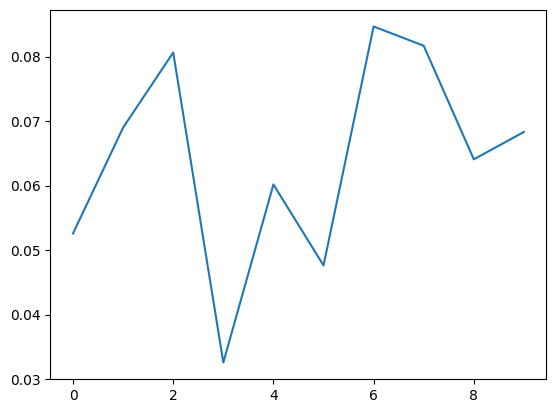

In [40]:
import matplotlib.pyplot as plt
## Plot the losse on a scale of 0 to 1
plt.plot(epoch_losses)

In [ ]:
## Evaluate the model on the validation set
model.eval()
val_losses = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        print(f'Validation loss: {loss.item()}')
        val_losses.append(loss.item())


### Visualizations for Tuning 

In [ ]:
## This is a random sample of Reddit texts to compare against embeddings for recipes

## Load dataset from ./dataset/blogtext.csv
blogset = pd.read_csv('./dataset/blogtext.csv')

## Drop all columns except text
blogset = blogset.drop(columns=['id', 'gender', 'age', 'topic', 'sign', 'date'])

## Drop all rows with text length < 800 and > 1100
blogset = blogset[blogset['text'].apply(lambda x: len(x) > 800 and len(x) < 1100)]

## Keep a random sample of 20100 rows
blogset = blogset.sample(n=20100, random_state=1)

blogset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20100 entries, 130204 to 589336
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20100 non-null  object
dtypes: object(1)
memory usage: 314.1+ KB


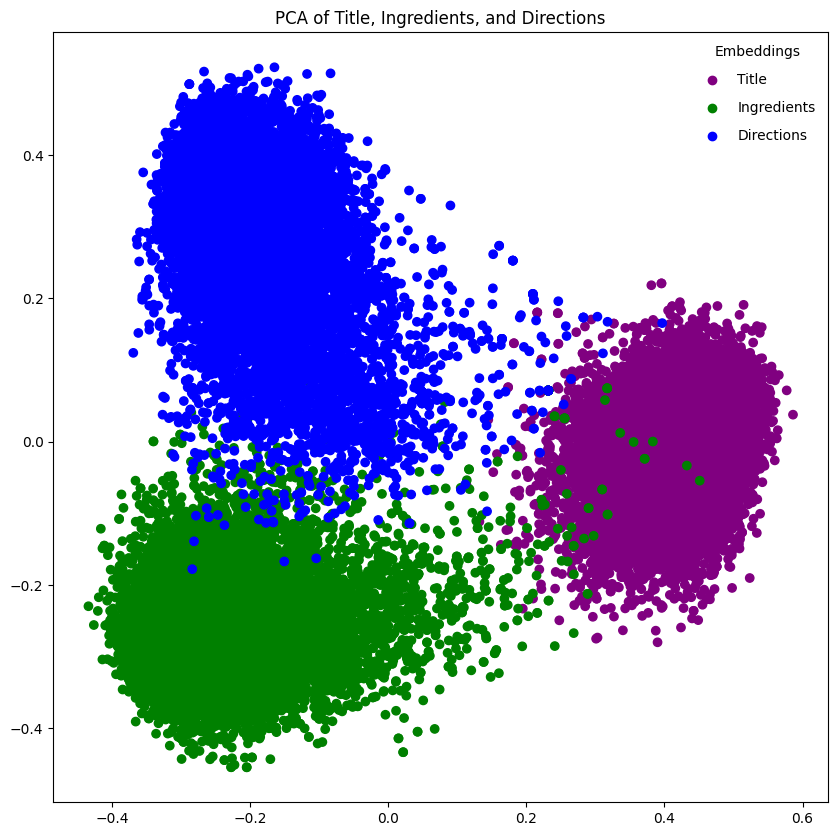

In [41]:
## Create a visualization of the embeddings using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate the embeddings
pca_embeddings = np.concatenate([train_title_embeddings.numpy(), train_ingredients_embeddings.numpy(), train_directions_embeddings.numpy()], axis=0)

# Create a color array
colors = ['purple'] * train_size + ['green'] * train_size + ['blue'] * train_size 

# Apply PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(pca_embeddings)

# Plot the result
plt.figure(figsize=(10, 10))
legend = ['Title', 'Ingredients', 'Directions']
for color in ['purple', 'green', 'blue']:
    plt.scatter([], [], c=color, label=legend.pop(0))
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Embeddings')
plt.title('PCA of Title, Ingredients, and Directions')
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)


2024-02-01 23:23:44.293732: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6646133760 exceeds 10% of free system memory.


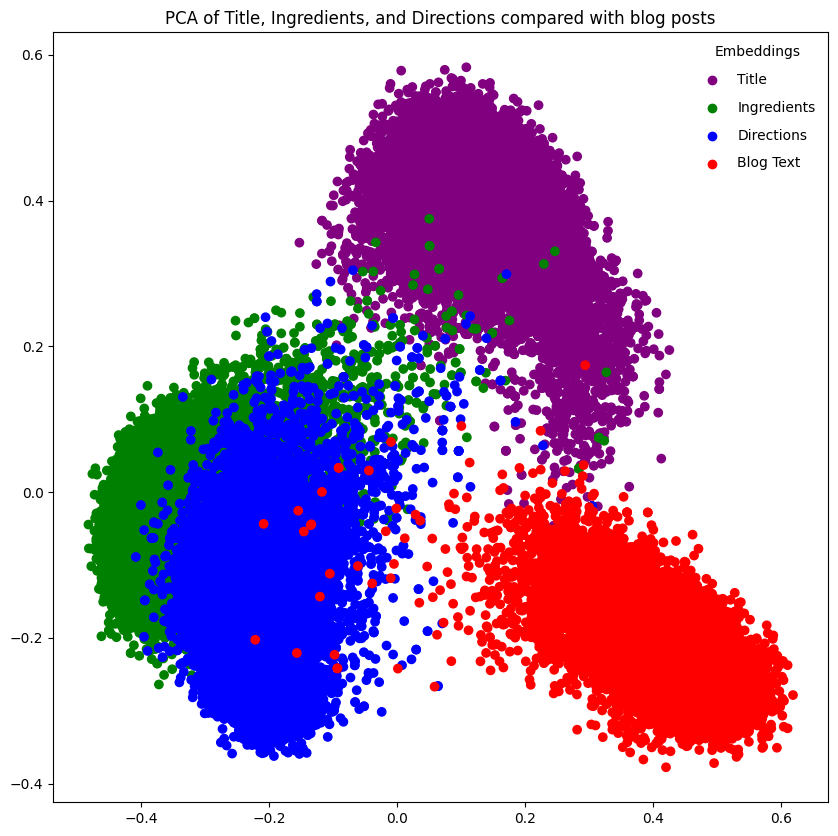

In [ ]:
## Create a visualization of the embeddings using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# directions = dataset['directions']
# average_length = sum(len(direction) for direction in directions) / len(directions)
# print(f"Average length of directions: {average_length}")

random_blog_embeddings = embed(blogset['text'][:train_size])

# Concatenate the embeddings
pca_embeddings = np.concatenate([train_title_embeddings.numpy(), train_ingredients_embeddings.numpy(), train_directions_embeddings.numpy(), random_blog_embeddings.numpy()], axis=0)

# Create a color array
colors = ['purple'] * train_size + ['green'] * train_size + ['blue'] * train_size + ['red'] * train_size

# Apply PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(pca_embeddings)

# Plot the result
plt.figure(figsize=(10, 10))
legend = ['Title', 'Ingredients', 'Directions', 'Blog Text']
for color in ['purple', 'green', 'blue', 'red']:
    plt.scatter([], [], c=color, label=legend.pop(0))
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Embeddings')
plt.title('PCA of Title, Ingredients, and Directions compared with blog posts')
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)


In [63]:
# print('FC1: avg:',model.fc1.weight.mean(), 'std:', model.fc1.weight.std(), 'min:', model.fc1.weight.min(), 'max:', model.fc1.weight.max())  
# print('FC2: avg:',model.fc2.weight.mean(), 'std:', model.fc2.weight.std(), 'min:', model.fc2.weight.min(), 'max:', model.fc2.weight.max())
# print('FC3: avg:',model.fc3.weight.mean(), 'std:', model.fc3.weight.std(), 'min:', model.fc3.weight.min(), 'max:', model.fc3.weight.max())
# print('FC4: avg:',model.fc4.weight.mean(), 'std:', model.fc4.weight.std(), 'min:', model.fc4.weight.min(), 'max:', model.fc4.weight.max())

# print('FC1: avg:',model.fc1.weight.mean().item(), 'std:', model.fc1.weight.std().item(), 'min:', model.fc1.weight.min().item(), 'max:', model.fc1.weight.max().item())
# layer_stats = []

# layer_stats[0] = model.fc1.weight.mean().item(), model.fc1.weight.std().item(), model.fc1.weight.min().item(), model.fc1.weight.max().item()
# layer_stats[1] = model.fc2.weight.mean().item(), model.fc2.weight.std().item(), model.fc2.weight.min().item(), model.fc2.weight.max().item()
# layer_stats[2] = model.fc3.weight.mean().item(), model.fc3.weight.std().item(), model.fc3.weight.min().item(), model.fc3.weight.max().item()
# layer_stats[3] = model.fc4.weight.mean().item(), model.fc4.weight.std().item(), model.fc4.weight.min().item(), model.fc4.weight.max().item()

print(model.fc1.weight.shape)
print(model.fc2.weight.shape)
print(model.fc3.weight.shape)
print(model.fc4.weight.shape)

print(torch.histogram(model.fc1.weight))

torch.Size([256, 2048])
torch.Size([128, 256])
torch.Size([64, 128])
torch.Size([1, 64])
torch.return_types.histogram(
hist=tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 6.0000e+00, 6.0000e+00, 1.0000e+00,
        4.0000e+00, 2.0000e+00, 5.0000e+00, 8.0000e+00, 7.0000e+00, 4.0000e+00,
        1.2000e+01, 1.4000e+01, 2.0000e+01, 2.5000e+01, 2.3000e+01, 3.6000e+01,
        4.1000e+01, 5.8000e+01, 6.4000e+01, 9.3000e+01, 1.3100e+02, 1.7300e+02,
        2.2400e+02, 3.1500e+02, 4.7000e+02, 6.9000e+02, 1.0170e+03, 1.5180e+03,
        2.2480e+03, 3.4450e+03, 4.9180e+03, 1.3129e+04, 2.2517e+04, 2.6909e+04,
        3.7786e+04, 4.5142e+04, 4.6221e+04, 4.7015e+04, 4.6866e+04, 4.6588e+04,
        4.5649e+04, 4.1825e+04, 2.9035e+04, 2.4026e+04, 1.7237e+04, 6.2930e+03,
        3.8410e+03, 2.6900e+03, 1.7440e+03, 1.1960e+03, 8.3100e+02, 5.4400e+

In [19]:
## Visualize spread of activation values in the nn layers

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


NameError: name 'layers' is not defined

<Figure size 2000x400 with 0 Axes>

In [ ]:
## Visualize deviation gradients of values in the nn layers

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')



In [ ]:
## Visualize distribution of weights in the nn layers

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');



In [ ]:
## Visualize the ratio of gradients to data in the nn layers (learning rate should land this near ~.003)

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

